**This notebooks contains the weighted ensemble model where I train and validate the model in which I have combined pRCC, cam-16 and WBC (trained with masks)
At the end, I have also added code that would load the model and do validation, which can be used by the evaluators**

In [7]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import os

**Defining the class that was used for pRCC**

In [ ]:
#pRCC

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 128, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 3, kernel_size=2, stride=2),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
import torch

pRCC = Autoencoder()
pRCC.load_state_dict(torch.load('/content/drive/My Drive/my_pRCC_autoencoder_128_64_20_epochs.pth'))
pRCC.eval()



Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 128, kernel_size=(2, 2), stride=(2, 2))
    (1): ReLU()
    (2): ConvTranspose2d(128, 3, kernel_size=(2, 2), stride=(2, 2))
    (3): Sigmoid()
  )
)

**Defining the class that was used for cam-16**

In [ ]:
# Create a CNN model
class CNNModel(nn.Module):

    def __init__(self):
        super(CNNModel, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)


        self.fc1 = nn.Linear(128 * 48 * 48, 128)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))


        x = x.view(x.size(0), -1)

        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
cam_16 = CNNModel()
cam_16.load_state_dict(torch.load('/content/drive/My Drive/my_cam16_model.pth'))
cam_16.eval()

CNNModel(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=294912, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)

**Defining the WBC class**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BasicResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.shortcut = nn.Sequential()

        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.shortcut(x)
        out = self.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, num_classes=5):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(BasicResidualBlock, 64, 2)
        self.layer2 = self._make_layer(BasicResidualBlock, 128, 2, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(128, 5)

    def _make_layer(self, block, out_channels, num_blocks, stride=1):
        layers = []
        layers.append(block(self.in_channels, out_channels, stride))
        self.in_channels = out_channels
        for _ in range(1, num_blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.maxpool(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [ ]:
!pip install torchinfo


In [ ]:
from torchinfo import summary

wbc = ResNet()
summary(wbc, input_size=(3, 575, 575), batch_dim=0,
            col_names=["input_size", "output_size", "num_params", "kernel_size", "mult_adds"], verbose=1)

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Kernel Shape              Mult-Adds
ResNet                                   [1, 3, 575, 575]          [1, 5]                    --                        --                        --
├─Conv2d: 1-1                            [1, 3, 575, 575]          [1, 64, 288, 288]         9,408                     [7, 7]                    780,337,152
├─BatchNorm2d: 1-2                       [1, 64, 288, 288]         [1, 64, 288, 288]         128                       --                        128
├─ReLU: 1-3                              [1, 64, 288, 288]         [1, 64, 288, 288]         --                        --                        --
├─MaxPool2d: 1-4                         [1, 64, 288, 288]         [1, 64, 144, 144]         --                        3                         --
├─Sequential: 1-5                        [1, 64, 144, 144]         [1, 64, 144, 144]         --

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Kernel Shape              Mult-Adds
ResNet                                   [1, 3, 575, 575]          [1, 5]                    --                        --                        --
├─Conv2d: 1-1                            [1, 3, 575, 575]          [1, 64, 288, 288]         9,408                     [7, 7]                    780,337,152
├─BatchNorm2d: 1-2                       [1, 64, 288, 288]         [1, 64, 288, 288]         128                       --                        128
├─ReLU: 1-3                              [1, 64, 288, 288]         [1, 64, 288, 288]         --                        --                        --
├─MaxPool2d: 1-4                         [1, 64, 288, 288]         [1, 64, 144, 144]         --                        3                         --
├─Sequential: 1-5                        [1, 64, 144, 144]         [1, 64, 144, 144]         --

In [ ]:
#combined with all 3

**Creating a Weighted Ensemble Model that would combine pRCC, cam-16 and WBC (trained with masks)**

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from sklearn.metrics import f1_score, confusion_matrix

class WeightedVotingEnsemble(nn.Module):
    def __init__(self, model_a, model_b, model_c, weight_a, weight_b, weight_c, num_classes):
        super(WeightedVotingEnsemble, self).__init__()
        self.model_a = model_a
        self.model_b = model_b
        self.model_c = model_c
        self.weight_a = weight_a
        self.weight_b = weight_b
        self.weight_c = weight_c
        self.linear_transform = nn.Linear(2, num_classes)

    def forward(self, x):
        predictions_a = self.model_a(x)
        predictions_b = self.model_b(x)
        latent_data = self.model_c(x)

        predictions_c = self.model_a(latent_data)

        transformed_predictions_a = self.linear_transform(predictions_a)
        transformed_predictions_c = self.linear_transform(predictions_c)

        weighted_predictions = (self.weight_a * transformed_predictions_a) + (self.weight_b * predictions_b) + (self.weight_c * transformed_predictions_c)


        return weighted_predictions


In [ ]:

transform = transforms.Compose([
    transforms.Resize((384, 384)),
    transforms.ToTensor(),
    ])


train_dir = '/content/drive/My Drive/WBC_with_mask/WBC_1/train/data'
val_dir = '/content/drive/My Drive/dataset/WBC_100/val/data'

# Load data from the 'train' directory
train_data = datasets.ImageFolder(train_dir, transform=transform)
train_loader = DataLoader(train_data, batch_size=4, shuffle=True)
# Load data from the 'val' directory
val_data = datasets.ImageFolder(val_dir, transform=transform)
val_loader = DataLoader(val_data, batch_size=4)

In [ ]:

state_dict_a = torch.load('/content/drive/My Drive/my_cam16_model.pth')
state_dict_b = torch.load('/content/drive/My Drive/my_best_my_wbc_1_model.pth')  #wbc trained with masks
state_dict_c = torch.load('/content/drive/My Drive/mypRCC_autoencoder_128_64_20ep.pth')

num_classes = 5

model_a = CNNModel()
model_b = ResNet(num_classes=num_classes)
model_c = Autoencoder()
model_a.load_state_dict(state_dict_a)
model_b.load_state_dict(state_dict_b)
model_c.load_state_dict(state_dict_c)

model_a.eval()
model_b.eval()
model_c.eval()

num_classes = len(train_data.classes)

#prediction weightage

weight_a = 0.2
weight_b = 0.6
weight_c = 0.2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


w_ensemble = WeightedVotingEnsemble(model_a, model_b, model_c, weight_a, weight_b, weight_c, num_classes).to(device)

In [ ]:
print(w_ensemble)

WeightedVotingEnsemble(
  (model_a): CNNModel(
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (fc1): Linear(in_features=294912, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=2, bias=True)
  )
  (model_b): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicResidualBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchN

**Model Training**

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(w_ensemble.parameters(), lr=0.001)
validation_accuracy_list = []
f1_score_list = []



training_loss = []
training_accuracy = []
for epoch in range(20):
    print("in epoch:", epoch)
    w_ensemble.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        #print("inside batch")
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = w_ensemble(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Epoch {epoch + 1}, Loss: {running_loss / len(train_loader)}, Training Accuracy: {accuracy:.2f}%")
    training_loss.append(running_loss / len(train_loader))
    training_accuracy.append(accuracy)

in epoch: 0
Epoch 1, Loss: 0.9202483711035355, Training Accuracy: 59.55%
in epoch: 1
Epoch 2, Loss: 0.869409688141035, Training Accuracy: 67.42%
in epoch: 2
Epoch 3, Loss: 0.8405794838200444, Training Accuracy: 66.29%
in epoch: 3
Epoch 4, Loss: 0.8227594093136166, Training Accuracy: 70.79%
in epoch: 4
Epoch 5, Loss: 0.7410657626131306, Training Accuracy: 75.28%
in epoch: 5
Epoch 6, Loss: 0.8401161406351172, Training Accuracy: 74.16%
in epoch: 6
Epoch 7, Loss: 0.8025957903136378, Training Accuracy: 70.79%
in epoch: 7
Epoch 8, Loss: 0.8344895463922749, Training Accuracy: 67.42%
in epoch: 8
Epoch 9, Loss: 0.7289284189110217, Training Accuracy: 71.91%
in epoch: 9
Epoch 10, Loss: 0.7093055248260498, Training Accuracy: 71.91%
in epoch: 10
Epoch 11, Loss: 0.652259208585905, Training Accuracy: 76.40%
in epoch: 11
Epoch 12, Loss: 0.618086792204691, Training Accuracy: 80.90%
in epoch: 12
Epoch 13, Loss: 0.7220592498779297, Training Accuracy: 78.65%
in epoch: 13
Epoch 14, Loss: 0.5394292985615523

In [ ]:
torch.save(w_ensemble.state_dict(), '/content/drive/My Drive/my_weighted_combined_wbc_1.pth')

In [ ]:
print(training_loss)
print(training_accuracy)

[0.9202483711035355, 0.869409688141035, 0.8405794838200444, 0.8227594093136166, 0.7410657626131306, 0.8401161406351172, 0.8025957903136378, 0.8344895463922749, 0.7289284189110217, 0.7093055248260498, 0.652259208585905, 0.618086792204691, 0.7220592498779297, 0.5394292985615523, 0.5870612095231595, 0.5594192898791769, 0.48222952498042065, 0.5564343791616999, 0.3776173805413039, 0.4384103879008604]
[59.550561797752806, 67.41573033707866, 66.29213483146067, 70.78651685393258, 75.28089887640449, 74.15730337078652, 70.78651685393258, 67.41573033707866, 71.91011235955057, 71.91011235955057, 76.40449438202248, 80.89887640449439, 78.65168539325843, 82.02247191011236, 77.52808988764045, 80.89887640449439, 79.7752808988764, 80.89887640449439, 87.64044943820225, 87.64044943820225]


**Validation done by me**

In [ ]:
print("doing val")
    # Perform validation after all epochs
w_ensemble.eval()  # Set the model to evaluation mode
with torch.no_grad():
    true_labels = []
    predicted_labels = []

    for inputs, labels in val_loader:
        #print("inside val batch")
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = w_ensemble(inputs)
        _, predicted = torch.max(outputs, 1)

        # Append true and predicted labels for F1 score
        true_labels += labels.tolist()
        predicted_labels += predicted.tolist()

    # Calculate F1 score
    f1 = f1_score(true_labels, predicted_labels, average='weighted')

    # Calculate overall accuracy
    correct_predictions = (np.array(true_labels) == np.array(predicted_labels)).sum()
    total_predictions = len(true_labels)
    overall_accuracy = 100 * correct_predictions / total_predictions

    # Calculate and store the confusion matrix
    confusion = confusion_matrix(true_labels, predicted_labels)

    # Print metrics for the final validation
    print('Final Validation Metrics:')
    print(f'Validation Accuracy: {overall_accuracy:.2f}%')
    print(f'F1 Score: {f1:.2f}')

    # Print the confusion matrix for the final validation
    print('Confusion Matrix (Final Validation):')
    print(confusion)

doing val
Final Validation Metrics:
Validation Accuracy: 71.53%
F1 Score: 0.68
Confusion Matrix (Final Validation):
[[ 31   1   1   0   3]
 [  0  10  32   0  84]
 [  0   1 325   0  86]
 [  2   7  22   0  64]
 [  3   1 185   0 870]]


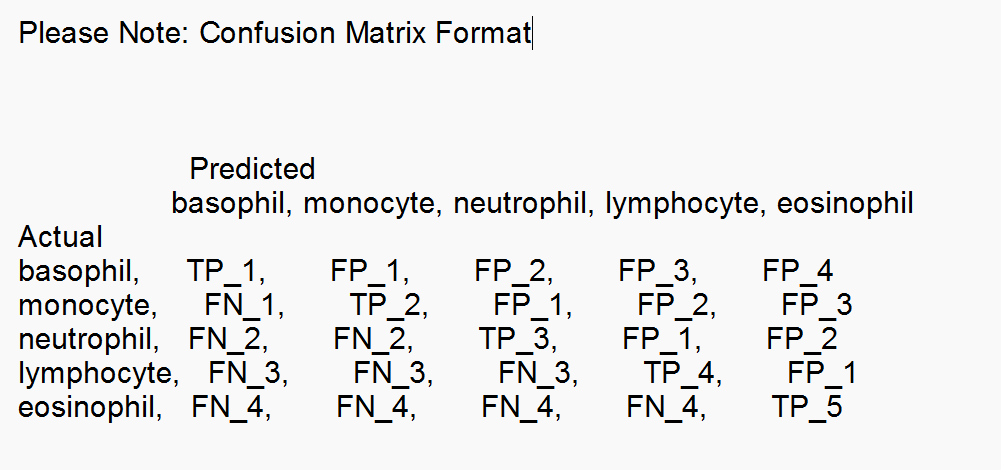

**Class-wise Detailed Report**

In [ ]:
from sklearn.metrics import classification_report

report = classification_report(true_labels, predicted_labels, target_names=train_data.classes)


In [ ]:
print(report)

              precision    recall  f1-score   support

    Basophil       0.86      0.86      0.86        36
  Eosinophil       0.50      0.08      0.14       126
  Lymphocyte       0.58      0.79      0.67       412
    Monocyte       0.00      0.00      0.00        95
  Neutrophil       0.79      0.82      0.80      1059

    accuracy                           0.72      1728
   macro avg       0.54      0.51      0.49      1728
weighted avg       0.67      0.72      0.68      1728



**Validation code for evaluators**

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from sklearn.metrics import f1_score, confusion_matrix

class WeightedVotingEnsemble(nn.Module):
    def __init__(self, model_a, model_b, model_c, weight_a, weight_b, weight_c, num_classes):
        super(WeightedVotingEnsemble, self).__init__()
        self.model_a = model_a
        self.model_b = model_b
        self.model_c = model_c
        self.weight_a = weight_a
        self.weight_b = weight_b
        self.weight_c = weight_c
        self.linear_transform = nn.Linear(2, num_classes)

    def forward(self, x):

        predictions_a = self.model_a(x)
        predictions_b = self.model_b(x)
        latent_data = self.model_c(x)

        predictions_c = self.model_a(latent_data)

        transformed_predictions_a = self.linear_transform(predictions_a)
        transformed_predictions_c = self.linear_transform(predictions_c)

        weighted_predictions = (self.weight_a * transformed_predictions_a) + (self.weight_b * predictions_b) + (self.weight_c * transformed_predictions_c)


        return weighted_predictions



In [2]:
#pRCC

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 128, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 3, kernel_size=2, stride=2),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [5]:
# cam-16
class CNNModel(nn.Module):

    def __init__(self):
        super(CNNModel, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)


        self.fc1 = nn.Linear(128 * 48 * 48, 128)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))


        x = x.view(x.size(0), -1)

        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [6]:
# wbc
import torch
import torch.nn as nn
import torch.nn.functional as F

class BasicResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.shortcut = nn.Sequential()

        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.shortcut(x)
        out = self.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, num_classes=5):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(BasicResidualBlock, 64, 2)
        self.layer2 = self._make_layer(BasicResidualBlock, 128, 2, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(128, 5)

    def _make_layer(self, block, out_channels, num_blocks, stride=1):
        layers = []
        layers.append(block(self.in_channels, out_channels, stride))
        self.in_channels = out_channels
        for _ in range(1, num_blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.maxpool(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [ ]:

transform = transforms.Compose([
    transforms.Resize((384, 384)),
    transforms.ToTensor(),
    ])


val_dir = '/content/drive/My Drive/dataset/WBC_100/val/data' #kindly change the test data path

val_data = datasets.ImageFolder(val_dir, transform=transform)
val_loader = DataLoader(val_data, batch_size=4)
vl = len(val_loader.dataset)
print("Length of the dataset:", vl)

In [10]:
# The weighted ensemble combines the trained models
state_dict_a = torch.load('/content/drive/My Drive/my_cam16_model.pth')   #change path to the cam-16 model. this would be in the sub-folder called 'models/cam-16'
state_dict_b = torch.load('/content/drive/My Drive/my_best_my_wbc_1_model.pth')  #path to the wbc-1 (trained with masks) model. this would be in the sub-folder called 'models/wbc with masks (intermediary step)'
state_dict_c = torch.load('/content/drive/My Drive/mypRCC_autoencoder_128_64_20ep.pth') #path to the pRCC autoencoder. this would be in the sub-folder called 'models/pRCC'

num_classes = 5
# Create model instances and load the state dictionaries
model_a = CNNModel()
model_b = ResNet(num_classes=num_classes)
model_c = Autoencoder()
# Load the state dictionaries into the models
model_a.load_state_dict(state_dict_a)
model_b.load_state_dict(state_dict_b)
model_c.load_state_dict(state_dict_c)

model_a.eval()
model_b.eval()
model_c.eval()

num_classes = 5

#prediction weightage
weight_a = 0.2
weight_b = 0.6
weight_c = 0.2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


w_ensemble = WeightedVotingEnsemble(model_a, model_b, model_c, weight_a, weight_b, weight_c, num_classes).to(device)

In [ ]:
state_dict_w = torch.load('/content/drive/My Drive/my_weighted_combined_wbc_1.pth')  #path to trained weighted ensemble wbc 1. this would be in the sub-folder called 'models/wbc with additional info (masks and pre-training)'


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

w_ensemble = WeightedVotingEnsemble(model_a, model_b, model_c, weight_a, weight_b, weight_c, num_classes).to(device)

w_ensemble.load_state_dict(state_dict_w)

w_ensemble.eval()

In [ ]:
print("doing val")
    # Perform validation after all epochs
w_ensemble.eval()  # Set the model to evaluation mode
with torch.no_grad():
    true_labels = []
    predicted_labels = []

    for inputs, labels in val_loader:
        #print("inside val batch")
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = w_ensemble(inputs)
        _, predicted = torch.max(outputs, 1)

        # Append true and predicted labels for F1 score
        true_labels += labels.tolist()
        predicted_labels += predicted.tolist()

    # Calculate F1 score
    f1 = f1_score(true_labels, predicted_labels, average='weighted')

    # Calculate overall accuracy
    correct_predictions = (np.array(true_labels) == np.array(predicted_labels)).sum()
    total_predictions = len(true_labels)
    overall_accuracy = 100 * correct_predictions / total_predictions

    # Calculate and store the confusion matrix
    confusion = confusion_matrix(true_labels, predicted_labels)

    # Print metrics for the final validation
    print('Final Validation Metrics:')
    print(f'Validation Accuracy: {overall_accuracy:.2f}%')
    print(f'F1 Score: {f1:.2f}')

    # Print the confusion matrix for the final validation
    print('Confusion Matrix (Final Validation):')
    print(confusion)

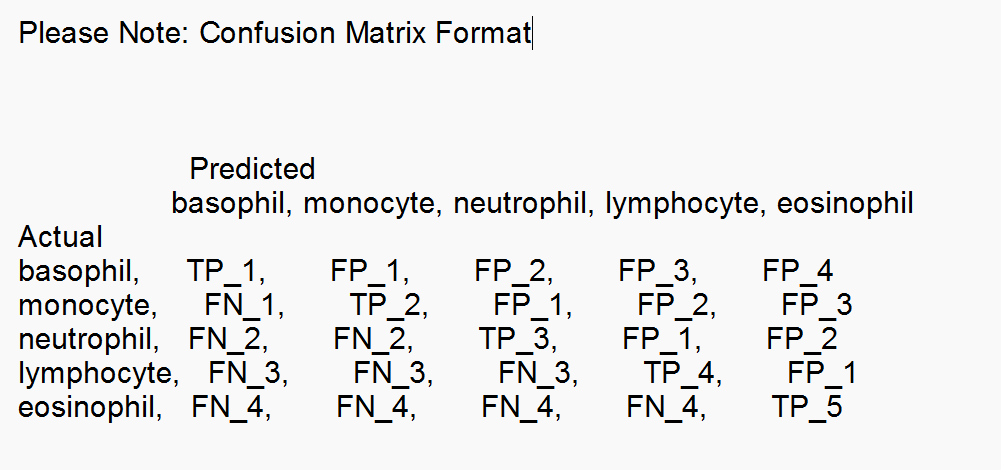

**Class-wise Detailed Report**

In [ ]:
from sklearn.metrics import classification_report

report = classification_report(true_labels, predicted_labels, target_names=train_data.classes)


In [ ]:
print(report)